In [39]:
import pyspark
#sc = pyspark.SparkContext('local[*]')

from datetime import datetime
from pyspark.sql.functions import col, udf,from_unixtime
from pyspark.sql.types import DateType
from pyspark.sql import SQLContext
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import StringType

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

ImportError: No module named mpld3

In [5]:
sqlContext = SQLContext(sc)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load("final_merged_data_2015_2016.csv")
df = df.withColumn("dayOfWeek",from_unixtime(unix_timestamp(df.starttime,'MM-dd-yyyy'), 'EEEEE'))
df.printSchema()

root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: integer (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- dayOfWeek: string (nullable = true)



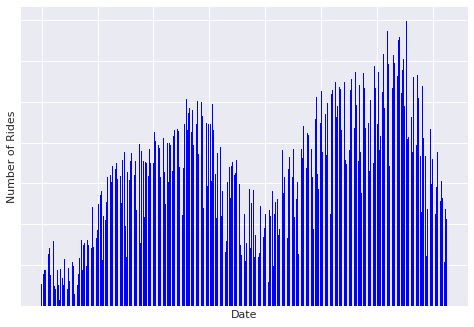

In [7]:
#per day rides
df.registerTempTable("citibike")
per_day_rides = """
                select 
                    DATE(starttime) as date,
                    count(*) as COUNT
                from citibike 
                group by 
                    DATE(starttime)
                order by date
          """

df_per_day_rides = sqlContext.sql(per_day_rides)
#df_per_day_rides.select("date","COUNT").show()

each_day_rides_list = df_per_day_rides.select("COUNT").rdd.flatMap(lambda x: x).collect()

N = len(each_day_rides_list)
x = range(N)
width = 1/1.5
plt.bar(x, each_day_rides_list, width, color="blue")
plt.ylabel('Number of Rides')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelleft='off') 

plt.show()

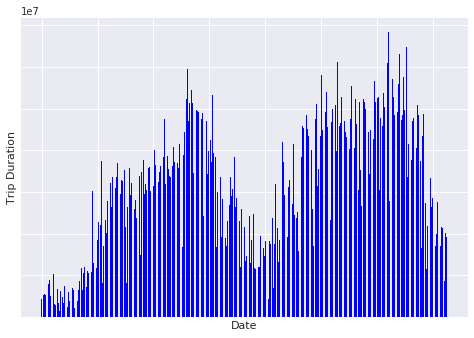

In [8]:
#trip duration per day
df.registerTempTable("citibike")
trip_duration_per_day = """
                select 
                    DATE(starttime) as date,
                    SUM(tripduration) as total_duration
                from citibike 
                group by 
                    DATE(starttime)
                order by date
            """

df_trip_duration_per_day = sqlContext.sql(trip_duration_per_day)
#df_trip_duration_per_day.select("date","total_duration").show()

trip_duration_list = df_trip_duration_per_day.select("total_duration").rdd.flatMap(lambda x: x).collect()
N = len(trip_duration_list)
x = range(N)
width = 1/1.5
plt.bar(x, trip_duration_list, width, color="blue")
plt.ylabel('Trip Duration')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelleft='off') 
plt.show()

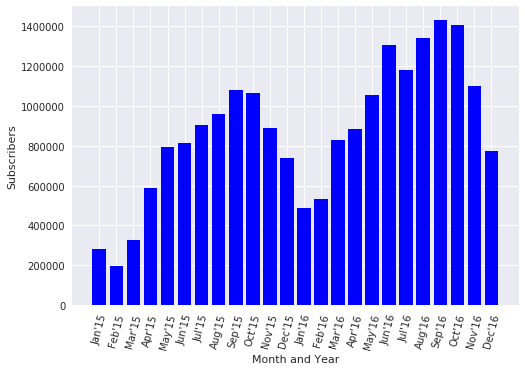

In [9]:
# Subsribers over months
df.registerTempTable("citibike")
subcriber_increase_query = """select MONTH(starttime) as month, YEAR(starttime) as year, count(*) as subscriber_count 
            from citibike 
            where usertype = 'Subscriber'
            group by MONTH(starttime), YEAR(starttime)
            order by year, month"""

df_subcriber_increase_query = sqlContext.sql(subcriber_increase_query)
#df_subcriber_increase_query.select("month","year","subscriber_count").show()

#Visualization
subscriber_count_list = df_subcriber_increase_query.select("subscriber_count").rdd.flatMap(lambda x: x).collect()
LABELS = ["Jan'15", "Feb'15", "Mar'15", "Apr'15", "May'15","Jun'15","Jul'15","Aug'15","Sep'15","Oct'15","Nov'15","Dec'15","Jan'16", "Feb'16", "Mar'16", "Apr'16", "May'16","Jun'16","Jul'16","Aug'16","Sep'16","Oct'16","Nov'16","Dec'16"]
N = len(subscriber_count_list)
x = range(N)
width = 0.8
plt.bar(x, subscriber_count_list, width, color="blue")
plt.ylabel('Subscribers')
plt.xlabel('Month and Year')
plt.xticks(x, LABELS, rotation=75)

plt.show()

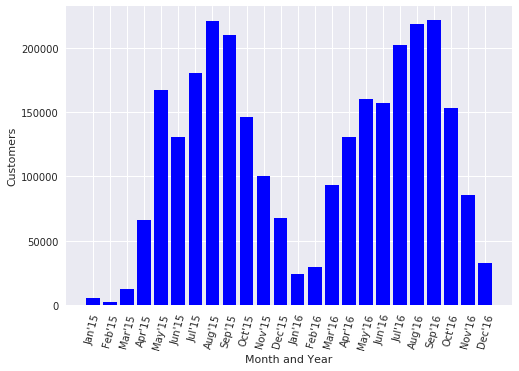

In [10]:
# Customers over months
df.registerTempTable("citibike")
customer_increase_query = """select MONTH(starttime) as month, YEAR(starttime) as year, count(*) as customer_count 
            from citibike 
            where usertype = 'Customer'
            group by MONTH(starttime), YEAR(starttime)
            order by year, month"""

df_customer_increase_query = sqlContext.sql(customer_increase_query)
#df_customer_increase_query.select("month","year","customer_count").show()

#Visualization
customer_count_list = df_customer_increase_query.select("customer_count").rdd.flatMap(lambda x: x).collect()
LABELS = ["Jan'15", "Feb'15", "Mar'15", "Apr'15", "May'15","Jun'15","Jul'15","Aug'15","Sep'15","Oct'15","Nov'15","Dec'15","Jan'16", "Feb'16", "Mar'16", "Apr'16", "May'16","Jun'16","Jul'16","Aug'16","Sep'16","Oct'16","Nov'16","Dec'16"]
N = len(customer_count_list)
x = range(N)
width = 0.8
plt.bar(x, customer_count_list, width, color="blue")
plt.ylabel('Customers')
plt.xlabel('Month and Year')
plt.xticks(x, LABELS, rotation=75)

plt.show()

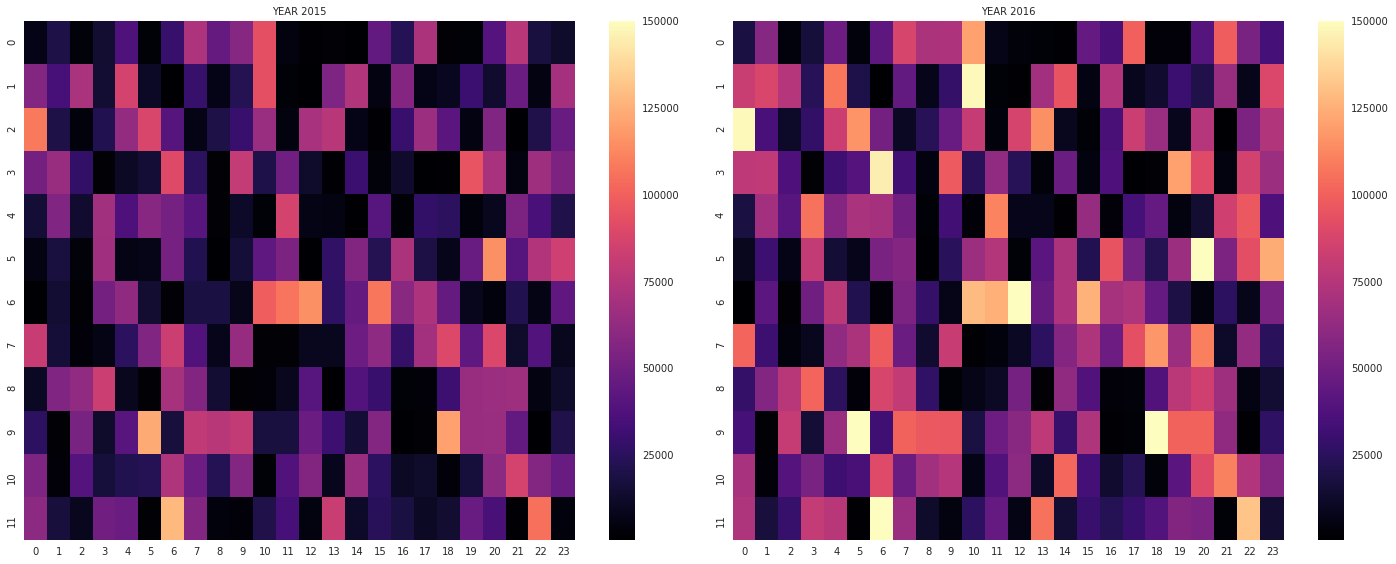

In [12]:
#Rides per month per hour
month_hour_query_2015 = """
    select 
        month(starttime) as month, 
        hour(starttime) as hour,
        Count(*) as numRides 
    from citibike 
    where year(starttime) = 2015 
    group by month(starttime),hour(starttime)"""

df_month_hour_rides_2015 = sqlContext.sql(month_hour_query_2015)
#df_month_hour_rides_2015.printSchema()
#df_month_hour_rides_2015.select('month','hour','numRides').show();

pdf_month_hour_rides_2015 = df_month_hour_rides_2015.select('numRides').toPandas()
temp_list_2015 = pdf_month_hour_rides_2015.as_matrix().reshape(12,24)

#print (temp_list_2015)

month_hour_query_2016 = """
    select 
        month(starttime) as month, 
        hour(starttime) as hour,
        Count(*) as numRides 
    from citibike 
    where year(starttime) = 2016 
    group by month(starttime),hour(starttime)"""

df_month_hour_rides_2016 = sqlContext.sql(month_hour_query_2016)
#df_month_hour_rides_2016.printSchema()
#df_month_hour_rides_2016.select('month','hour','numRides').show();


pdf_month_hour_rides_2016 = df_month_hour_rides_2016.select('numRides').toPandas()
temp_list_2016 = pdf_month_hour_rides_2016.as_matrix().reshape(12,24)

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(temp_list_2015, cmap='magma', label='2015', vmax=150000, vmin=500)
plt.title('YEAR 2015', size=10)

plt.subplot(1, 2, 2)
sns.heatmap(temp_list_2016, cmap='magma', label='2016', vmax=150000, vmin=500)
plt.title('YEAR 2016', size=10)

plt.tight_layout()
plt.show()

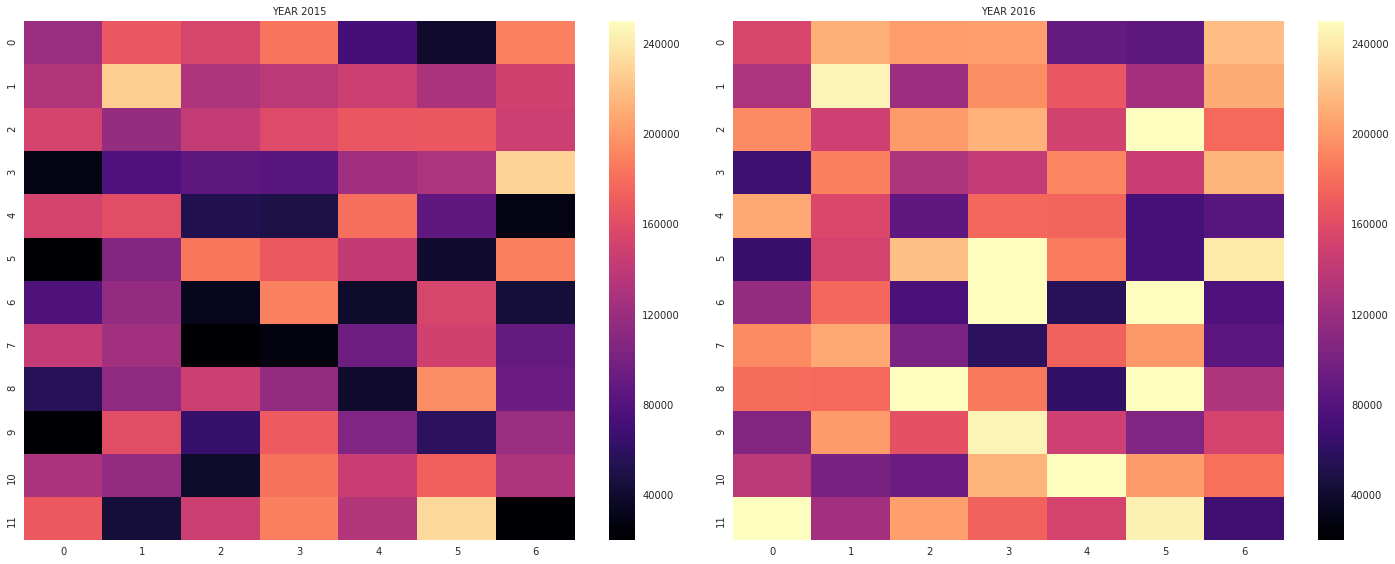

In [13]:
#rides per day of the week per month
df.registerTempTable("citibike")
month_week_query_2015 = """
    select 
        MONTH(starttime) as month,
        dayOfWeek,
        count(*) as numRides 
    from citibike
    where YEAR(starttime) = 2015
    group by 
        month(starttime),
        dayOfWeek"""

#sqlContext.sql(month_day_query).show()
df_month_week_rides_2015 = sqlContext.sql(month_week_query_2015)
#df_month_week_rides_2015.select('month','dayOfWeek','numRides').show();

month_week_right_list_2015 = df_month_week_rides_2015.select('numRides').toPandas()
month_week_right_list_2015 = month_week_right_list_2015.as_matrix().reshape(12,7)


#rides per day of the week per month
df.registerTempTable("citibike")
month_week_query_2016 = """
    select 
        MONTH(starttime) as month,
        dayOfWeek,
        count(*) as numRides 
    from citibike
    where YEAR(starttime) = 2016
    group by 
        month(starttime),
        dayOfWeek"""

#sqlContext.sql(month_day_query).show()
df_month_week_rides_2016 = sqlContext.sql(month_week_query_2016)
#df_month_week_rides_2016.select('month','dayOfWeek','numRides').show();

month_week_right_list_2016 = df_month_week_rides_2016.select('numRides').toPandas()
month_week_right_list_2016 = month_week_right_list_2016.as_matrix().reshape(12,7)

#print(month_week_right_list_2015)
#print(month_week_right_list_2016)

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.heatmap(month_week_right_list_2015, cmap='magma', label='2015', vmax=250000, vmin=20000)
plt.title('YEAR 2015', size=10)

plt.subplot(1, 2, 2)
sns.heatmap(month_week_right_list_2016, cmap='magma', label='2016', vmax=250000, vmin=20000)
plt.title('YEAR 2016', size=10)

plt.tight_layout()
plt.show()

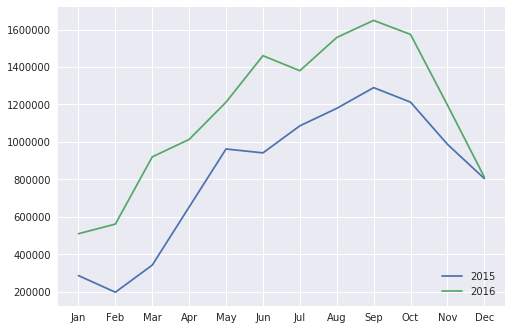

In [51]:
#time series
time_series_query = """select year(starttime) as year, month(starttime) as month, count(*) as rides
                from citibike
                group by year(starttime), month(starttime)
                order by year, month
            """
df_time_series = sqlContext.sql(time_series_query)
df_time_series.registerTempTable("citibike_time_series")

time_series_query_2015 = """select * from citibike_time_series where year = 2015"""

df_time_series_2015 = sqlContext.sql(time_series_query_2015)
# df_time_series_2015.printSchema()
# df_time_series_2015.select("year","month","rides").show()

time_series_query_2016 = """select * from citibike_time_series where year = 2016"""
df_time_series_2016 = sqlContext.sql(time_series_query_2016)
# df_time_series_2016.printSchema()
# df_time_series_2016.select("year","month","rides").show()

numrides_list_2015 = df_time_series_2015.select('rides').toPandas()
numrides_list_2015 = numrides_list_2015.as_matrix()

numrides_list_2016 = df_time_series_2016.select('rides').toPandas()
numrides_list_2016 = numrides_list_2016.as_matrix()

month_list = range(1, 13)

LABELS = ["Jan", "Feb", "Mar", "Apr", "May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
plt.plot(month_list,numrides_list_2015)
plt.plot(month_list,numrides_list_2016)
plt.legend(['2015', '2016'], loc='lower right')
plt.xticks(month_list, LABELS, rotation=0)
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


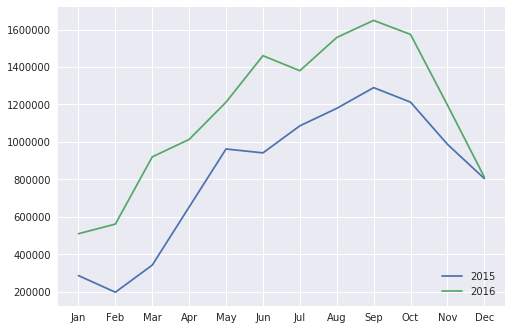